In [1]:
from xraycam.nbinit import *
camcontrol.set_detector('zwo')
from xraycam.camalysis import *

In [2]:
class Monitor:
    def __init__(self, *args, transpose = True, vmax = 150, rebin = 1, **kwargs):
        self.run = camcontrol.DataRun(*args, **kwargs)
        self.vmax = vmax
        self.rebin = rebin

    def frame(self):
        return self.run.get_frame()
    
    def update(self):
        self.run.show(vmax = self.vmax)
        self.run.plot_lineout(rebin = self.rebin)
        self.frame().plot_histogram(xmin = 0, xmax = self.vmax)
        
    def stop(self):
        self.run.stop()

#### code for runset arrays

In [3]:
from xraycam.camcontrol import _rebin_spectrum

In [4]:
def rebin_spc(arr2d,rebin=5):
    lineout = np.sum(arr2d,axis=0)/110
    return _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]

In [5]:
def _reorient_array(arr2d):
    """Take output from the get_array() method for dataruns from the new camera,
    and reorient them to match what our usual analysis code expects."""
    return np.transpose(arr2d[::,::-1])

NOTe to self Will: you changed the fitregionx on the below function definition because center_of_masses was throwing NaN

fitregionmode='man',fitregionx=[500,800]

In [6]:
def plot_with_energy_scale_arr2d(arr2d,known_energy,known_bin=None, photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange)[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,known_bin=known_bin,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()

Note to self: need to fix the get_parabolic_lineout portion of this function.  See below.  Only works when cropping upper regions of the sensor because the fitregion needs to have the same x index range as the shape passed into parabolic_sort

In [7]:
def plot_with_energy_scale_arr2d_test(arr2d,known_energy,known_bin=None, photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange,fitregionmode='man',fitregiony=yrange)[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,known_bin=known_bin,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()

don't need the function right beneath this anymore (had to make specific to zns to get it to work temporarily)

In [8]:
def plot_with_energy_scale_arr2d_zns(arr2d,known_energy,photon_value=110,yrange=[0,-1],xrange=[0,-1],rebin=1,show=True,peaknormalize=False, label=None,calcfwhm=False,parabolic=False,**kwargs):
    if parabolic == False:
        lineout = np.sum(arr2d[yrange[0]:yrange[1],xrange[0]:xrange[1]],axis=0)/photon_value
    else:
        lineout = get_parabolic_lineout(arr2d,yrange=yrange,fitregionmode='man',fitregionx=[537-150,537+150])[xrange[0]:xrange[1]]/photon_value
    if rebin != 1: #rebin using oliver's rebin_spectrum function
        lineout = _rebin_spectrum(np.array(range(len(lineout))),lineout,rebin)[1]
    if peaknormalize == True:
        lineout = lineout / max(lineout)
    lineout_energyscale=add_energy_scale(lineout,known_energy,rebinparam=rebin,**kwargs)
    if label == None and calcfwhm == False:
        label=datarun.prefix
    elif label == None and calcfwhm == True:
        s=' - '
        label=s.join((str(datarun.prefix),str(fwhm_ev(lineout_energyscale,3))))
    elif label != None and calcfwhm == True:
        s=' - '
        label=s.join((label,str(fwhm_ev(lineout_energyscale))))
    camcontrol.plt.plot(*lineout_energyscale,label=label)
    if show == True:
        camcontrol.plt.show()

In [9]:
def cropping_tool_arr2d(datarun,step,known_energy=2014,calcfwhm=True,**kwargs):
    [plot_with_energy_scale_arr2d(datarun,known_energy,label='['+','.join((str(i),str(i+step)))+']',yrange=[i,i+step],
                            show=False,calcfwhm=calcfwhm,**kwargs) for i in range(0,2000,step)]
    camcontrol.plt.show()

# Doing ZnS
* He flow set at 0.5
* gain:213 exposure:50ms

In [11]:
zns0 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = '9.22.zns0')

Loaded from cache.


In [12]:
zns1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.zns1')
zns1.run.theta=105

Loaded from cache.


In [13]:
zns2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.zns2')
zns2.run.theta=110

Loaded from cache.


In [14]:
zns3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.zns3')
zns3.run.theta=115

Loaded from cache.


move translation stage on camera 3 turns right and 2 turns down

In [11]:
zns4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.zns4')
zns4.run.theta=115

Loaded from cache.


In [109]:
zns3.stop()

In [62]:
[x.run.counts_per_second() for x in (zns2,zns3,zns4)]

[6.9262100774508371, 6.6538475733811975, 7.3129389961415185]

old datarun to compare with

In [496]:
labdata = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = 'zns0.contd.9.15')

Loaded from cache.


In [65]:
zns4.run.acquisition_time()

2324.2945976257324

In [66]:
zns4.stop()

In [118]:
plot_with_energy_scale_arr2d_zns(_reorient_array(zns4.run.get_array()),2307.7,label="zns",rebin=2,calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale(zns4.run,2307.7,label="zns",rebin=2,calcfwhm=True,show=False,peaknormalize=True)
plot_with_energy_scale(zns4.run,2307.7,label="zns",rebin=2,yrange=[500,1000],calcfwhm=True,show=False,peaknormalize=True)
plot_with_energy_scale(labdata.run,2307.7,label="zns",rebin=1,yrange=[500,1000],calcfwhm=True,show=False,peaknormalize=True)
plt.show()

<IPython.core.display.Javascript object>


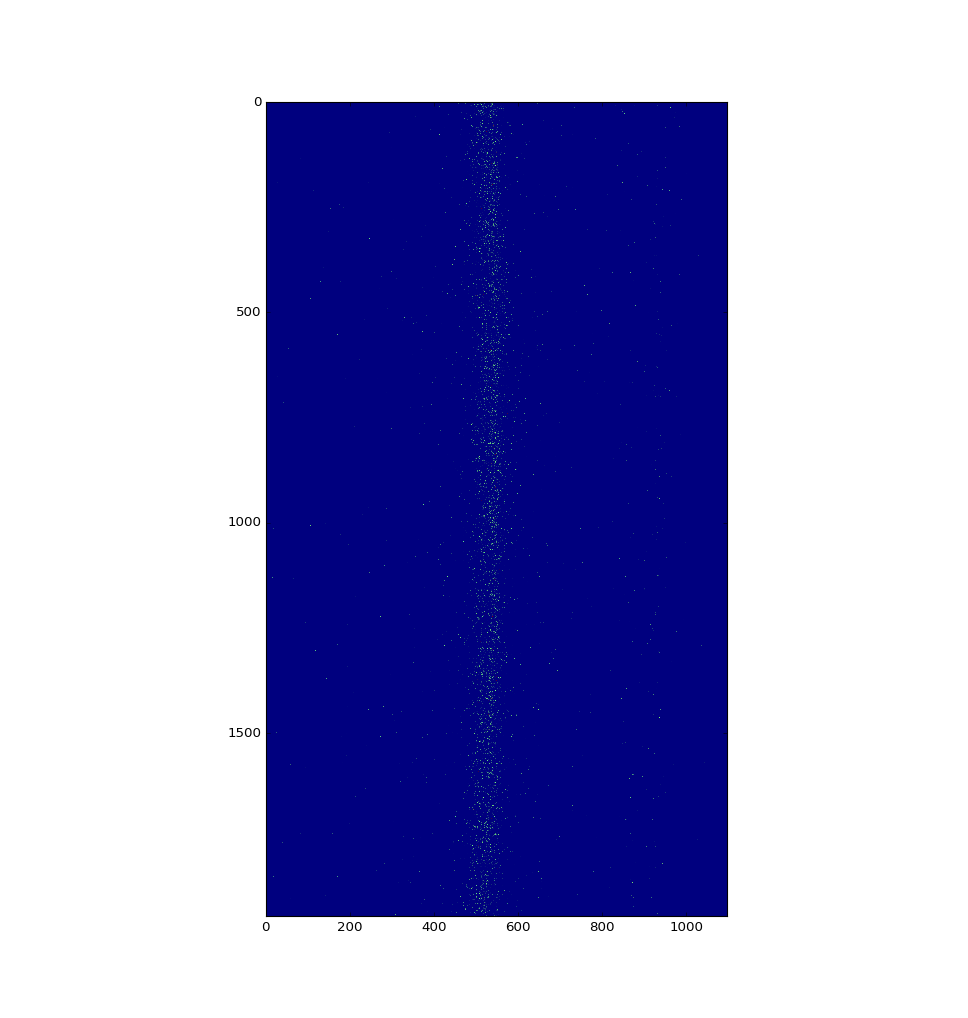

In [46]:
zns4.run.show(vmax=250)

In [48]:
cmplot(_reorient_array(zns4.run.get_array()),smooth=10)

# Looking good, take long runset

In [10]:
znsrunset0 = camcontrol.RunSet(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            prefix = '9.22.znsrunset0',htime="5m",number_runs=24)

Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.


In [202]:
[x.counts_per_second() for x in znsrunset0.dataruns]

[7.8936311700534478,
 7.3433149248035336,
 7.1796689499269917,
 6.9272106414599266,
 7.4319124652511359,
 7.1420005783927429,
 7.5169244985178478,
 7.486958765100197,
 6.9000292188940735,
 7.3066551339587846,
 7.056340226542817,
 7.2325044416436572,
 7.0996449666229315,
 7.4639419524810817,
 7.6935305770466229,
 7.0562674201307916,
 7.4124055826709778,
 7.0174198355717596,
 7.2943022424472588,
 7.0994233276683483,
 7.1264630286979997,
 7.4982943293208475,
 7.1308143025426975,
 7.4017917531317456]

In [151]:
[x.acquisition_time() for x in znsrunset0.dataruns]

[300.11536502838135,
 300.1779999732971,
 300.1310067176819,
 300.20558190345764,
 300.16414499282837,
 300.18822050094604,
 300.105849981308,
 300.20560479164124,
 300.1862144470215,
 300.2166278362274,
 300.1904618740082,
 300.1583812236786,
 300.1905083656311,
 300.20414996147156,
 300.2037830352783,
 300.2036819458008,
 300.1831645965576,
 300.0989942550659,
 300.15926241874695,
 300.2065875530243,
 300.1310758590698,
 300.2217164039612,
 300.1816611289978,
 300.13646602630615]

In [12]:
znsarr0=_reorient_array(np.sum([x.get_array() for x in znsrunset0.dataruns],axis=0))

In [13]:
znsarrtotal=_reorient_array(zns4.run.get_array())+znsarr0

In [29]:
#plot_with_energy_scale_arr2d(znsarrtotal,2307.7,label="zns",rebin=2,calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(znsarrtotal,2307.7,label="zns",rebin=2,yrange=[0,1500],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(znsarrtotal,2307.7,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
#plot_with_energy_scale_arr2d(znsarr0,2307.7,label="zns",rebin=2,calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
#plot_with_energy_scale(labdata.run,2307.7,label="zns",rebin=2,yrange=[500,1000],calcfwhm=True,show=False,peaknormalize=True)
plt.show()

<IPython.core.display.Javascript object>


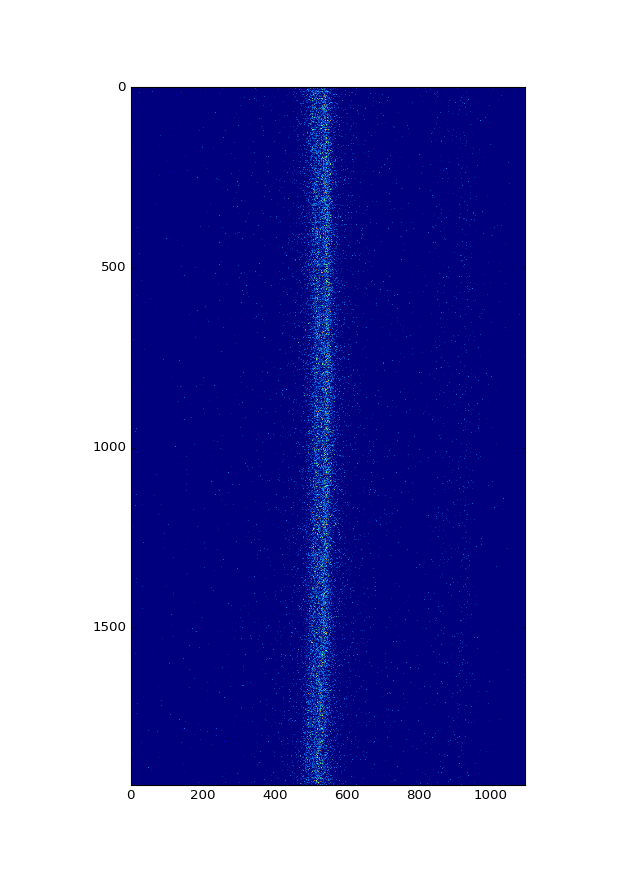

In [24]:
plt.imshow(znsarrtotal,vmax=500)
plt.show()

In [28]:
cropping_tool_arr2d(znsarrtotal,300,rebin=2)

# Now pure Sulfur

DON't USE THESE!

In [152]:
sulfur0 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = '9.22.sulfur0')
sulfur0.run.theta=35

In [152]:
sulfur1 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = '9.22.sulfur1')
sulfur1.run.theta=30

oops forgot to change window again

In [163]:
sulfur2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfur2')
sulfur2.run.theta=30

In [177]:
sulfur3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfur3')
sulfur3.run.theta=35

In [84]:
sulfur4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfur4')
sulfur4.run.theta=30

Loaded from cache.


In [25]:
sulfurrunset0 = camcontrol.RunSet(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            prefix = '9.22.sulfurrunset0',htime="5m",number_runs=12)

Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.


In [201]:
[x.run.counts_per_second() for x in (sulfur0,sulfur1,sulfur2,sulfur3,sulfur4)]

[0.0,
 0.34105408881022992,
 27.022732290699903,
 0.48425452994935925,
 31.761264649717642]

In [281]:
[x.counts_per_second() for x in sulfurrunset0.dataruns]

[31.930845761270113,
 32.045813412731285,
 32.311430579977142,
 31.524908877807579,
 31.831487445870117,
 31.602656156761412,
 31.427086794314935,
 31.617309728110669,
 31.675655485511797,
 31.241899573283348,
 30.952424268219598,
 31.535601774363332]

In [282]:
[x.acquisition_time() for x in sulfurrunset0.dataruns]

[300.1978557109833,
 300.1761498451233,
 300.1372859477997,
 300.20529103279114,
 300.1994068622589,
 300.2457592487335,
 300.26191115379333,
 300.1392376422882,
 300.2205445766449,
 300.1679663658142,
 300.1385543346405,
 300.29350876808167]

In [283]:
(np.argmax(np.sum(sulfurarr0,axis=0))-np.argmax(np.sum(znsarrtotal,axis=0)))*.082/2

0.20500000000000002

In [284]:
plt.plot(np.sum(znsarrtotal,axis=0)/max(np.sum(znsarrtotal,axis=0)),label='zns')
plt.plot(np.sum(sulfurarr0,axis=0)/max(np.sum(sulfurarr0,axis=0)),label='s')
plt.show()

In [26]:
sulfurarr0=_reorient_array(np.sum([x.get_array() for x in sulfurrunset0.dataruns],axis=0))

Note to self: if I crop them differently, the relative energy scale seems to shift... i.e. if sulfur yrange=[0,-1] and zns yrange=[0,1300], they appear to overlap, but if they have the same yrange, there appears to be a shift... 

In [286]:
plot_with_energy_scale_arr2d(sulfurarr0,2307.7,known_bin=539,label="S",rebin=2,yrange=[0,1300],calcfwhm=True,show=False,peaknormalize=False,parabolic=True)
plot_with_energy_scale_arr2d(znsarrtotal,2307.7,known_bin=539,label="zns",rebin=2,yrange=[0,1300],calcfwhm=True,show=False,peaknormalize=False,parabolic=True)
plot_with_energy_scale(labdata.run,2307.7,label="zns",rebin=2,yrange=[500,1000],calcfwhm=True,show=False,peaknormalize=True)
plt.show()

In [234]:
np.mean(center_of_masses(sulfurarr0))

542.42456346613881

In [235]:
np.mean(center_of_masses(znsarrtotal))

541.64533839246292

stopped acquisistion


In [247]:
cmplot(sulfurarr0,smooth=10)

In [248]:
cmplot(znsarrtotal,smooth=10)

# Next sample Na2S
* about 12pm now, in case that's relevant for I0

In [287]:
na2s0 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = '9.22.na2s0')
na2s0.run.theta=305

In [295]:
na2s1 = Monitor(threshold = 2, window_min = 104, window_max = 114, photon_value = 110,
            run_prefix = '9.22.na2s1')
na2s1.run.theta=300

wow can't believe I did it yet again...

In [302]:
na2s2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s2')
na2s2.run.theta=300

In [314]:
na2s3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s3')
na2s3.run.theta=300

missed.

In [320]:
na2s4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s4')
na2s4.run.theta=305

In [327]:
na2s5 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s5')
na2s5.run.theta=305

missed

In [332]:
na2s6 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s6')
na2s6.run.theta=310

In [338]:
na2s7 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s7')
na2s7.run.theta=295

In [351]:
na2s8 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s8')
na2s8.run.theta=290

In [359]:
na2s9 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s9')
na2s9.run.theta=290

In [366]:
na2s7.run.counts_per_second()

5.0960078440728589

In [363]:
na2s9.run.acquisition_time()

30.733176231384277

In [364]:
na2s9.stop()

In [365]:
na2s9.run.plot_lineout()

array([ 0.08730159,  0.02380952,  0.02380952, ...,  0.07142857,
        0.14285714,  0.06349206])

best position at theta=295 only gives 5counts/sec, let's check S-polymer

# S-polymer

In [367]:
spolymer0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.spolymer0')
spolymer0.run.theta=205

In [375]:
spolymer1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.spolymer1')
spolymer1.run.theta=210

increased He regulator exit from 3 to 4psi for no particular reason...

In [384]:
spolymer2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.spolymer2')
spolymer2.run.theta=200

In [391]:
spolymer2.run.acquisition_time()

42.73946213722229

In [388]:
spolymer2.run.counts_per_second()

0.54340829955495895

In [389]:
spolymer2.run.plot_lineout()

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [390]:
spolymer2.stop()

# Back to Na2S since it had higher counts

In [392]:
na2s10 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.na2s10')
na2s10.run.theta=295

In [399]:
na2s10.run.acquisition_time()

45.58143591880798

In [402]:
na2s10.run.counts_per_second()

8.7137909388251984

In [403]:
na2s10.run.plot_lineout()

array([ 0.07142857,  0.01587302,  0.07936508, ...,  0.03968254,
        0.1031746 ,  0.05555556])

In [404]:
na2s10.stop()

In [18]:
na2srunset0 = camcontrol.RunSet(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            prefix = '9.22.na2srunset0',htime="5m",number_runs=12)

Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.


In [8]:
na2srunset1 = camcontrol.RunSet(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            prefix = '9.22.na2srunset1',htime="5m",number_runs=6)

Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
Loaded from cache.
starting acquisition


In [40]:
na2srunset2 = camcontrol.RunSet(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            prefix = '9.22.na2srunset2',htime="5m",number_runs=6)

starting acquisition


In [68]:
[x.counts_per_second() for x in na2srunset2.dataruns]

[7.3048565941121044,
 7.0078053870700341,
 7.2578922835749831,
 7.2952178086168979,
 7.3118369885072259,
 7.3169882202122896]

In [69]:
[x.acquisition_time() for x in na2srunset2.dataruns]

[300.17646527290344,
 300.17549180984497,
 300.1078975200653,
 300.15422892570496,
 300.1905605792999,
 300.22652792930603]

In [19]:
na2sarr0=_reorient_array(np.sum([x.get_array() for x in na2srunset0.dataruns],axis=0))

In [33]:
na2sarr1=_reorient_array(np.sum([na2srunset1.dataruns[i].get_array() for i in (0,1,2,3,5)],axis=0))

In [70]:
na2sarr2=_reorient_array(np.sum([x.get_array() for x in na2srunset2.dataruns],axis=0))

In [71]:
na2sarrtotal=na2sarr0+na2sarr1+na2sarr2

In [72]:
plot_with_energy_scale_arr2d(na2sarrtotal,2307.7,known_bin=539,label="Na2S",rebin=2,yrange=[0,1400],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(sulfurarr0,2307.7,known_bin=539,label="S",rebin=2,yrange=[0,1400],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(znsarrtotal,2307.7,known_bin=539,label="zns",rebin=2,yrange=[0,1400],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plt.show()

In [493]:
plot_with_energy_scale_arr2d(na2sarrtotal,2307.7,known_bin=539,label="Na2S",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(sulfurarr0,2307.7,known_bin=539,label="S",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(znsarrtotal,2307.7,known_bin=539,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
#plot_with_energy_scale(sulfurposition0.run,2307.7,known_bin=539,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plt.show()

In [435]:
np.mean(center_of_masses(na2sarr0))

552.18683972658653

<IPython.core.display.Javascript object>


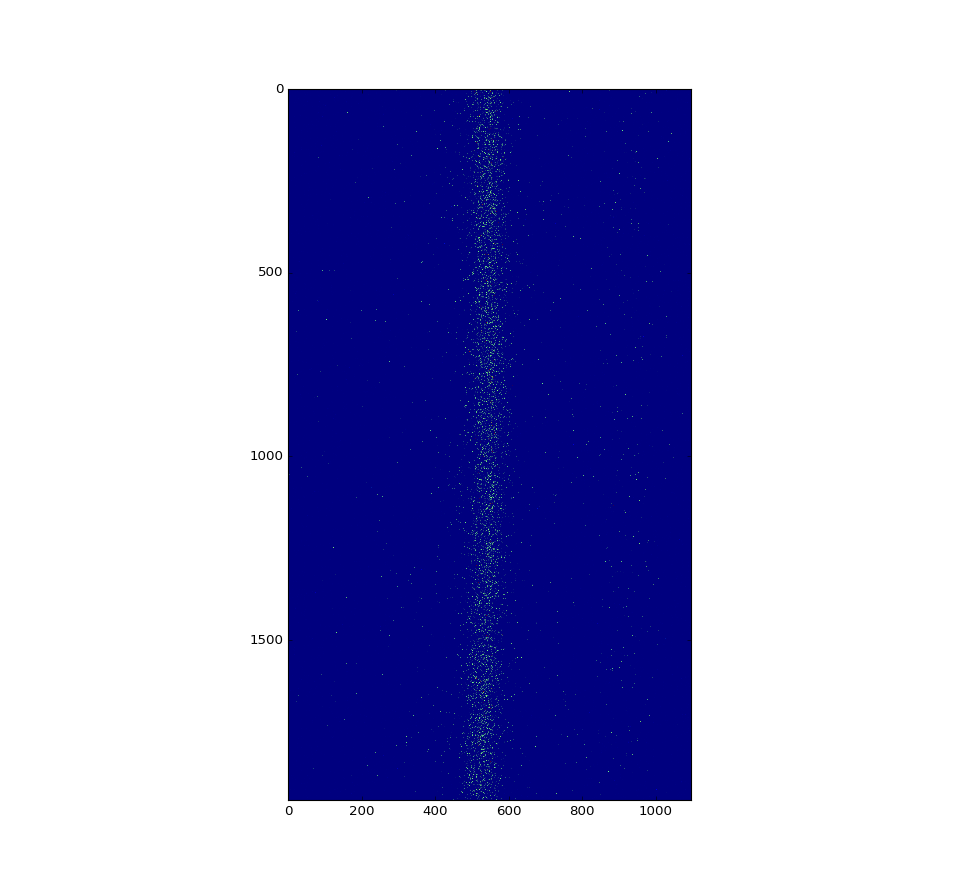

In [436]:
plt.imshow(na2sarr0, vmax=250)
plt.show()

#### Parabolic binning check stuff below

note to self: need to investigate different croppings/parabolic binnings

In [485]:
plot_with_energy_scale_arr2d(sulfurarr0,2307.7,known_bin=539,label="S",rebin=2,yrange=[0,900],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d_test(sulfurarr0,2307.7,known_bin=539,label="S",rebin=2,yrange=[900,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(sulfurarr0,2307.7,known_bin=539,label="S",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale_arr2d(sulfurarr0,2307.7,known_bin=539,label="S",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plt.show()

In [482]:
cropping_tool_arr2d(sulfurarr0,400,2300,peaknormalize=True)

# Now begin camera position study

With Sulfur, take data for camera different positions from window to see if line shape changes significantly.

Starting at same position as previous scans.  

In [73]:
sulfurposition0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition0')
sulfurposition0.run.theta=30

move camera 6 turns further away from window

In [139]:
sulfurposition1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition1')
sulfurposition1.run.theta=30
sulfurposition1.run.z=6

In [172]:
sulfurposition2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition2')
sulfurposition2.run.theta=30
sulfurposition2.run.z=-6

11 turns away from chamber from original position.  4 turns up.

In [202]:
sulfurposition3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurposition3')
sulfurposition3.run.theta=30
sulfurposition3.run.z=11

In [206]:
sulfurposition3.run.counts_per_second()

23.679470173621098

In [220]:
sulfurposition3.run.acquisition_time()

1200.6349818706512

In [218]:
sulfurposition3.stop()

In [494]:
plot_with_energy_scale(sulfurposition0.run,2307.7,known_bin=None,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale(sulfurposition1.run,2307.7,known_bin=None,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale(sulfurposition2.run,2307.7,known_bin=None,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale(sulfurposition3.run,2307.7,known_bin=None,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
#plot_with_energy_scale_arr2d(sulfurarr0,2307.7,known_bin=None,label="S",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plt.show()

In [122]:
sulfur4.run.plot_lineout(show=False,peaknormalize=True)
sulfurposition0.run.plot_lineout(peaknormalize=True)

array([ 0.00415177,  0.        ,  0.        , ...,  0.        ,
        0.        ,  0.        ])

# Now begin angular position study

In [1]:
sulfurangleposition0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurangleposition0')
sulfurangleposition0.run.theta=30

NameError: name 'Monitor' is not defined

In [259]:
sulfurangleposition1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurangleposition01')
sulfurangleposition1.run.theta=25

oops, not sure what broke. accidentally called sulfurangleposition0.stop() during sulfurangleposition1 run, and it seems to have done something inexplicable.  redoing...

In [283]:
sulfurangleposition2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurangleposition2')
sulfurangleposition2.run.theta=25

In [321]:
sulfurangleposition3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.sulfurangleposition3')
sulfurangleposition3.run.theta=35

In [327]:
sulfurangleposition3.run.counts_per_second()

0.30087125755459609

In [328]:
sulfurangleposition3.stop()

In [318]:
sulfurangleposition2.run.acquisition_time()

814.2292625904083

In [319]:
sulfurangleposition2.stop()

In [320]:
plot_with_energy_scale(sulfurangleposition0.run,2307.7,known_bin=100,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale(sulfurangleposition2.run,2307.7,known_bin=100,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plt.show()

<IPython.core.display.Javascript object>


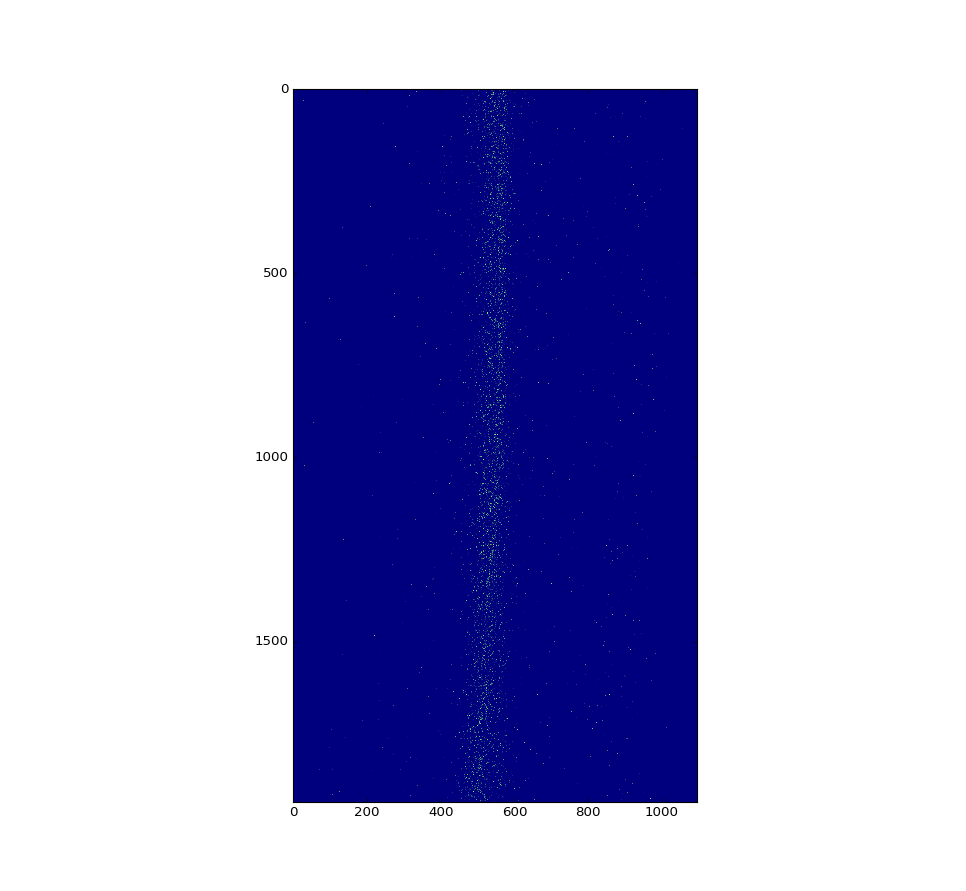

In [307]:
sulfurangleposition2.run.show(vmax=250)

In [329]:
plt.plot(gfilt(center_of_masses(_reorient_array(sulfurangleposition0.run.get_array())),10))
plt.plot(gfilt(center_of_masses(_reorient_array(sulfurangleposition2.run.get_array())),10))
plt.show()

# ZnS Angular Study

In [330]:
znsangleposition0 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsangleposition0')
znsangleposition0.run.theta=115

In [356]:
znsangleposition1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsangleposition1')
znsangleposition1.run.theta=120

In [370]:
znsangleposition2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsangleposition2')
znsangleposition2.run.theta=125

In [377]:
znsangleposition3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsangleposition3')
znsangleposition3.run.theta=110

In [414]:
znsangleposition4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsangleposition4')
znsangleposition4.run.theta=105

In [419]:
znsangleposition4.run.counts_per_second()

0.041701011890744856

In [418]:
znsangleposition4.run.acquisition_time()

7.374982833862305

In [420]:
znsangleposition4.stop()

In [410]:
plot_with_energy_scale(znsangleposition0.run,2307.7,known_bin=100,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plot_with_energy_scale(znsangleposition1.run,2307.7,known_bin=100,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plot_with_energy_scale(znsangleposition3.run,2307.7,known_bin=100,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plot_with_energy_scale(sulfurangleposition0.run,2307.7,known_bin=100,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plot_with_energy_scale(sulfurangleposition2.run,2307.7,known_bin=100,label="s",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=True)
plt.show()

In [395]:
znsangleposition0.run.show(vmax=250)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


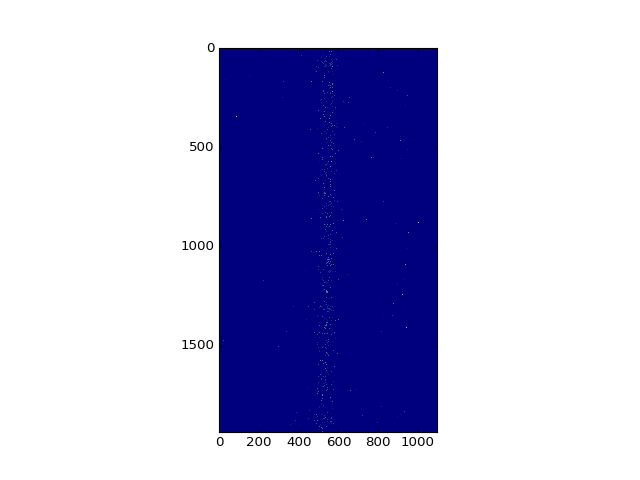

In [399]:
znsangleposition3.run.show(vmax=250)

hypothesis (Alex's): If the camera is not properly on the circle and tangent, then different sample position would refocus from different parts of the crystal and reach the camera at different angles.  Those angles become relevant if the camera is not on and tangent to the circle.

# Camera distance study on ZnS

In [421]:
znsdistance1 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsdistance1')
znsdistance1.run.theta=120
znsdistance1.run.z=0

In [447]:
znsdistance2 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsdistance2')
znsdistance2.run.theta=120
znsdistance2.run.z=11

also 4 turns up

In [453]:
znsdistance3 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsdistance3')
znsdistance3.run.theta=120
znsdistance3.run.z=11

down 5 turns

In [473]:
znsdistance4 = Monitor(threshold = 2, window_min = 120, window_max = 132, photon_value = 126,
            run_prefix = '9.22.znsdistance4')
znsdistance4.run.theta=120
znsdistance4.run.z=-8

In [479]:
znsdistance4.run.counts_per_second()

10.172744864426472

In [491]:
znsdistance4.run.acquisition_time()

900.9061822891235

In [490]:
znsdistance4.stop()

In [492]:
plot_with_energy_scale(znsdistance1.run,2307.7,known_bin=None,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plot_with_energy_scale(znsdistance3.run,2307.7,known_bin=None,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plot_with_energy_scale(znsdistance4.run,2307.7,known_bin=None,label="zns",rebin=2,yrange=[0,-1],calcfwhm=True,show=False,peaknormalize=True,parabolic=False)
plt.show()

# Investigating really unfortunate shift in peak position...

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


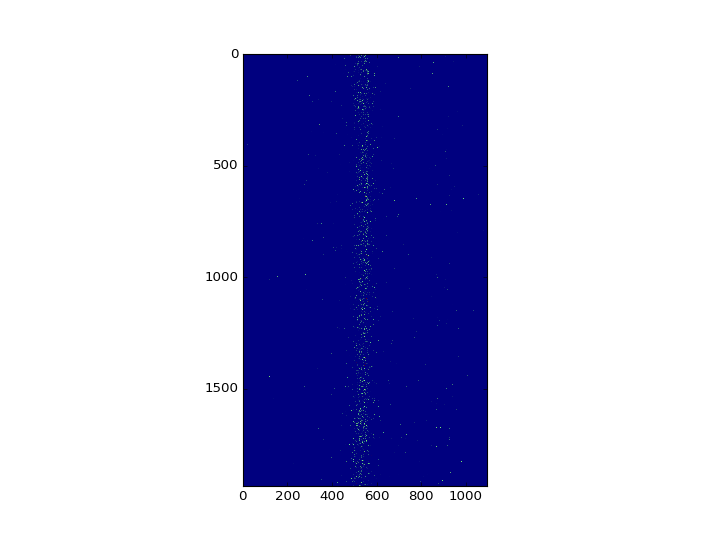

In [82]:
plt.imshow(sulfurarr0,vmax=250)
plt.show()
sulfurposition0.run.show(vmax=250)

In [136]:
sulfurposition0.run.acquisition_time()

1203.4684371948242

In [134]:
sulfurposition0.stop()

In [97]:
c=center_of_masses(_reorient_array(sulfurposition0.run.get_array()))

In [98]:
c=c[~np.isnan(c)]

In [99]:
np.mean(c)

548.96877183033143

In [96]:
np.mean(center_of_masses(sulfurarr0))

542.67290533782068

In [102]:
f1=quadfit(_reorient_array(sulfurposition0.run.get_array()))

In [119]:
f2=quadfit(sulfurarr0)

In [105]:
def quad_center(abc):
    (a,b,c)=abc
    return -b/(2*a)

In [116]:
quad_center(f2)-quad_center(f1)

-141.18915940358852

In [109]:
a = quad_center(f1)

In [112]:
f1[0]*a**2+f1[1]*a+f1[0]

-10.132337348273074

In [120]:
b = quad_center(f2)

In [121]:
f2[0]*b**2+f2[1]*b+f1[0]

-10.134048390146932

In [138]:
plt.plot(gfilt(center_of_masses(sulfurarr0),10))
plt.plot(gfilt(center_of_masses(na2sarrtotal),10))
plt.plot(gfilt(center_of_masses(_reorient_array(sulfurposition0.run.get_array())),10))
plt.show()